# Load package

In [11]:
import os
from pathlib import Path
import datetime as dt
import joblib

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from google.cloud import storage, bigquery


# Load common parameters

In [16]:
PROJECT = "mightyhive-data-science-poc"
TABLE_ID = f"{PROJECT}.data_drift_demo.bike_sharing"
SERVICE_PATH = Path.home().joinpath(".ssh", "mightyhive.json")
BUCKET_NAME = "data-drift-detection"
MODEL_FILE_NAME = "model.sav"

# Load training data from BigQuery

In [3]:
def load_data_from_bigquery(table_id, start=None, end=None):
    bq_client = bigquery.Client().from_service_account_json(SERVICE_PATH)
    query = (
        f"""
        SELECT
          count,
          temp,
          atemp,
          humidity,
          windspeed,
          season,
          holiday,
          workingday,
          EXTRACT(DAYOFWEEK FROM datetime) AS weekday,
          EXTRACT(HOUR FROM datetime) AS hour,
        FROM
          `{table_id}`
        """
    )

    if start and end:
        query = (
            f"""
            {query}
            WHERE DATE(datetime) BETWEEN "{start}" and "{end}"
            """
        )
    df= bq_client.query(query).result().to_dataframe()
    return df

In [4]:
start = "2011-01-01"
end = "2011-01-28"
df = load_data_from_bigquery(TABLE_ID, start, end)

In [5]:
df.head()

,count,temp,atemp,humidity,windspeed,season,holiday,workingday,weekday,hour
0,56,14.76,16.665,81,19.0012,1,0,0,7,11
1,70,14.76,16.665,71,16.9979,1,0,0,1,11
2,93,14.76,16.665,66,19.9995,1,0,0,1,12
3,53,14.76,16.665,46,22.0028,1,0,0,1,18
4,197,14.76,16.665,57,22.0028,1,0,1,4,17


In [6]:
X = df.drop(["count"], axis=1)
y = df["count"]

# Train a regression model

In [7]:
# train regressor model
regressor = RandomForestRegressor(random_state=0, n_estimators=50)
regressor.fit(X, y)

RandomForestRegressor(n_estimators=50, random_state=0)

# Save the model to GCS

In [13]:
_ = joblib.dump(regressor, MODEL_FILE_NAME)

In [17]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )
    
upload_blob(BUCKET_NAME, MODEL_FILE_NAME, MODEL_FILE_NAME)

File model.sav uploaded to model.sav.


# The model performance over time

In [8]:
def load_nth_four_weeks_data(table_id, n):
    """
    n: the nth interval. When n = 0, it is the training data.
    """
    interval = dt.timedelta(days=28)
    start = dt.date(2011, 1, 1) + interval * n
    end = start + interval
    df = load_data_from_bigquery(table_id, start, end)
    return df

In [9]:
def calculate_mae_nth_four_weeks_data(table_id, n, model):
    print(f"Calculating batch {n}")
    df = load_nth_four_weeks_data(table_id, n)
    X = df.drop(["count"], axis=1)
    y = df["count"]
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    return mae

Calculating batch 0
Calculating batch 1
Calculating batch 2
Calculating batch 3
Calculating batch 4
Calculating batch 5
Calculating batch 6
Calculating batch 7
Calculating batch 8
Calculating batch 9
Calculating batch 10
Calculating batch 11
Calculating batch 12
Calculating batch 13
Calculating batch 14
Calculating batch 15
Calculating batch 16
Calculating batch 17
Calculating batch 18
Calculating batch 19


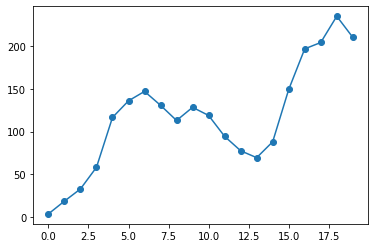

In [10]:
# mae on the training data
n_batch = 20
maes = [
    calculate_mae_nth_four_weeks_data(TABLE_ID, i, regressor) 
    for i in range(n_batch)
]
plt.plot(range(n_batch), maes)
plt.scatter(range(n_batch), maes)